# Rates per isotope

In this notebook I am going to make plots of the rates of events in a given detector coming from each isotope

In [1]:
from lib.lib_rates import *
import matplotlib.pyplot as plt

In [2]:
# This function is taken (and tweaked) from reactor_measurement.py, and it calculates event counts in 
# recoil energy bins in a given detector
# INPUT:
# - fission_rate_per_isotope (calculated from reactor properties: here, we are just considering one isotope at a time)
# - detector_material (e.g. Xenon, Germanium)
# - offset: how far the detector is from the reactor core
# - exposure: how long the detector will run for x the mass of the detector
# - bin_edges: the recoil energies at the edge of each bin

def get_bin_counts(fission_rate_per_isotope, detector_material, bin_edges, offset, exposure):
        bin_counts = []
        nbins = len(bin_edges) - 1
        for i in range(nbins):
            bin_counts.append(np.floor(quad(
                dR_dER, bin_edges[i], bin_edges[i+1], args=(detector_material, fission_rate_per_isotope, offset)
                )[0]*exposure))
        return bin_counts

In [14]:
def get_isotope_bin_counts(detector_material, offset, threshold, exposure, thermal_power, nbins):
    # Get target mass for given detector material
    mT = mTarget(detector_material)

    # Calculate the edges of the given bins
    ER_min = threshold
    ER_max = get_ER_max(FLUX_ENU_MAX, mT)

    bin_edges = np.logspace(np.log10(ER_min), np.log10(ER_max), nbins+1)

    # Get the no. of events in each bin for each fissile isotope
    bin_counts_per_isotope = []

    for i in range(4):
        fission_rate = (thermal_power/ENERGY_PER_FISSION_I[i])
        fission_rate_per_isotope = np.zeros(4)
        fission_rate_per_isotope[i] = fission_rate

        bin_counts_per_isotope.append(
            (bin_edges[:-1], 
             get_bin_counts(fission_rate_per_isotope, detector_material, bin_edges, offset, exposure))
             )

    return bin_counts_per_isotope
    

In [15]:
Xe10meter100ev_isotope_bin_counts_per_kgyear_GW = get_isotope_bin_counts(detector_material='Xe', offset=10*METER, threshold=0.1*keV, exposure=KILOGRAM*YEAR, thermal_power=GIGAWATT, nbins=25)
Si10meter100ev_isotope_bin_counts_per_kgyear_GW = get_isotope_bin_counts(detector_material='Si', offset=10*METER, threshold=0.1*keV, exposure=KILOGRAM*YEAR, thermal_power=GIGAWATT, nbins=25)

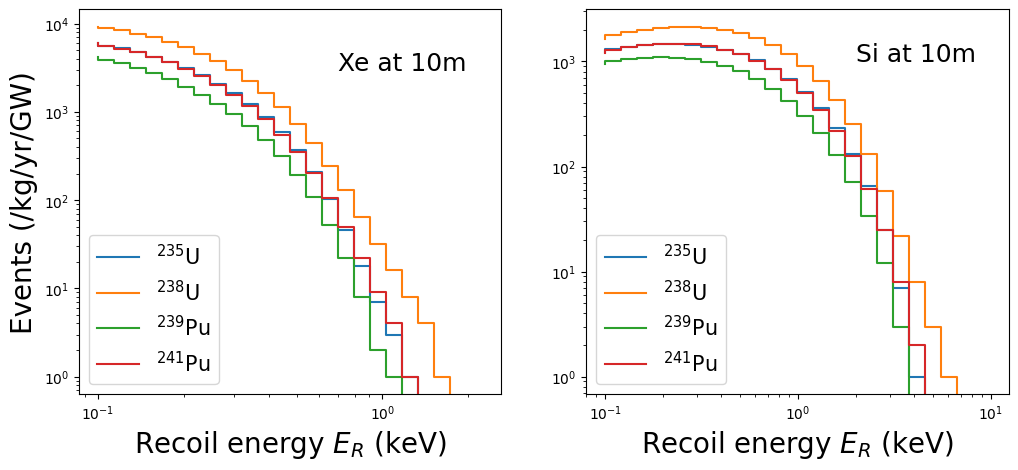

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

Xe_Si_bin_counts = [Xe10meter100ev_isotope_bin_counts_per_kgyear_GW, Si10meter100ev_isotope_bin_counts_per_kgyear_GW]

for ax, bin_counts_per_isotope in zip(axes, Xe_Si_bin_counts):
    for bc, isotope_string, in zip(bin_counts_per_isotope, FISSILE_ISOTOPES_LATEX_FORMAT):
        ax.step(bc[0]/keV, bc[1], where='pre', label=isotope_string)

    ax.set_xlabel("Recoil energy $E_R$ (keV)", fontsize=20)
    
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.legend(fontsize=15, loc='lower left')

axes[0].set_ylabel("Events (/kg/yr/GW)", fontsize=20)

axes[0].text(0.7, 3e3, "Xe at 10m", fontsize=18)
axes[1].text(2, 1e3, "Si at 10m", fontsize=18)

fig.savefig("./figures/recoil_spectra_per_isotope_Xe_Si.pdf", bbox_inches='tight')